In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import ast
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from itertools import combinations
from joblib import dump, load
import random
import numpy as np
from collections import defaultdict
random.seed(114514)

In [2]:
suits = ['c', 'd', 'h', 's']  # clubs, diamonds, hearts, spades
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']  # 2-10, Jack, Queen, King, Ace

deck = {rank + suit: i for i, (rank, suit) in enumerate((r, s) for r in ranks for s in suits)}

In [3]:
df = pd.read_csv('./out/5H1AI_logs.csv')

df['community_cards_flop'] = df['community_cards_flop'].fillna('[]')
df['community_cards_turn'] = df['community_cards_turn'].fillna('[]')
df['community_cards_river'] = df['community_cards_river'].fillna('[]')
df['community_cards_flop'] = df['community_cards_flop'].apply(ast.literal_eval)
df['community_cards_turn'] = df['community_cards_turn'].apply(ast.literal_eval)
df['community_cards_river'] = df['community_cards_river'].apply(ast.literal_eval)

for i in range(1, 7):
    df['player{}_action'.format(i)] = df['player{}_action'.format(i)].apply(ast.literal_eval)

df.head()

,community_cards_flop,community_cards_turn,community_cards_river,winners,uncalled_amount,pot,profits,players_active,player1_card,player1_action,player2_card,player2_action,player3_card,player3_action,player4_card,player4_action,player5_card,player5_action,player6_card,player6_action
0,"[7d, 5h, 9d]",[7c],[Qh],[1],230,520,"[310.0, -100.0, 0.0, -210.0, 0.0, 0.0]","[1, 0, 0, 0, 0, 0]","['Tc', 'Qc']","[calls 160, checks, checks, bets 230]","['8s', '4c']",[folds],"['9c', '3d']",[folds],"['Ah', '4h']","[raises 110 to 210, checks, checks, folds]","['Th', '5s']",[folds],"['6c', '7s']",[folds]
1,"[7s, 9c, Tc]",[2c],[],[3],600,940,"[-50.0, -445.0, 495.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0]","['Qh', '5c']",[folds],"['9h', '6h']","[calls 110, checks, calls 235, checks, folds]","['Kc', 'Jh']","[raises 110 to 210, bets 235, bets 600]","['8h', 'Qc']",[folds],"['7h', 'Kh']",[folds],"['Ks', '3c']",[folds]
2,[],[],[],[6],150,250,"[-50.0, -100.0, 0.0, 0.0, 0.0, 150.0]","[0, 0, 0, 0, 0, 1]","['Jc', '2c']",[folds],"['2d', 'Qh']",[folds],"['9d', 'Jh']",[folds],"['7c', '8h']",[folds],"['2s', '4c']",[folds],"['6s', 'Ks']",[raises 150 to 250]
3,"[3d, 6h, 9d]",[5s],[],[1],600,1015,"[620.0, -225.0, 0.0, -395.0, 0.0, 0.0]","[1, 0, 0, 0, 0, 0]","['8d', '8s']","[calls 175, bets 170, bets 600]","['2h', 'Kc']","[calls 125, folds]","['4s', '9s']",[folds],"['Kh', 'Qh']","[raises 125 to 225, calls 170, folds]","['2s', '7d']",[folds],"['7h', 'Jh']",[folds]
4,"[7c, Ah, Th]",[2s],[9h],[1],3500,3500,"[1800.0, -100.0, 0.0, 0.0, -1700.0, 0.0]","[1, 0, 0, 0, 0, 0]","['Ts', 'Ac']","[calls 200, checks, checks, raises 1050 to 145...","['2c', '5c']",[folds],"['7d', '3c']",[folds],"['7s', '8d']",[folds],"['2d', 'Ad']","[raises 150 to 250, checks, bets 400, calls 10...","['4s', '6s']",[folds]


In [4]:
# Royal Flush
royal_flushes = [list(f'{rank}{suit}' for rank in 'TJQKA') for suit in suits]

# Straight Flush (excluding Royal Flush)
straight_flushes = [list(f'{ranks[i+j]}{suit}' for j in range(5)) for suit in suits for i in range(9)]

# Four of a Kind
four_of_a_kind = [list(f'{rank}{suit}' for suit in suits) for rank in ranks]

# Full House
full_house = [list([f'{rank1}{suit}' for suit in [suit1, suit2, suit3]] + [f'{rank2}{suit}' for suit in [suit4, suit5]]) 
              for rank1 in ranks for rank2 in ranks if rank1 != rank2 
              for suit1, suit2, suit3 in combinations(suits, 3) 
              for suit4, suit5 in combinations([suit for suit in suits if suit not in [suit1, suit2, suit3]], 2)]

# Flush
flushes = [list(f'{rank}{suit}' for rank in combination) for suit in suits for combination in combinations(ranks, 5)]

# Straight
straights = [list(f'{rank}{suit}' for rank in ranks[i:i+5]) for suit in suits for i in range(9)]

# Three of a Kind
three_of_a_kind = [list(f'{rank}{suit}' for suit in [suit1, suit2, suit3]) 
                   for rank in ranks for suit1, suit2, suit3 in combinations(suits, 3)]

# Two Pair
two_pair = [list([f'{rank1}{suit}' for suit in [suit1, suit2]] + [f'{rank2}{suit}' for suit in [suit3, suit4]]) 
            for rank1 in ranks for rank2 in ranks if rank1 != rank2 
            for suit1, suit2 in combinations(suits, 2) 
            for suit3, suit4 in combinations([suit for suit in suits if suit not in [suit1, suit2]], 2)]

# One Pair
one_pair = [list([f'{rank1}{suit}' for suit in [suit1, suit2]] + [f'{rank2}{suit}' for suit in [suit3, suit4, suit5]])
            for rank1 in ranks for rank2 in ranks if rank1 != rank2
            for suit1, suit2 in combinations(suits, 2)
            for suit3, suit4, suit5 in combinations([suit for suit in suits if suit not in [suit1, suit2]], 3)]



good_hands = royal_flushes + straight_flushes + four_of_a_kind + full_house + flushes + straights + three_of_a_kind
extended_good_hands = []



for hand in good_hands:
    remaining_cards = [card for card in deck.keys() if card not in hand]
    for n in range(5 - len(hand), 8 - len(hand)):
        # Sample a subset of the remaining cards
        extra_cards = random.sample(remaining_cards, n)
        extended_hand = hand + list(extra_cards)
        extended_hand_pre = list(extra_cards) + hand
        extended_good_hands.append(extended_hand)
        extended_good_hands.append(extended_hand_pre)

# Convert each extended hand to a string
extended_good_hands_str = ['[\''+'\', \''.join(hand) + '\']' for hand in extended_good_hands]

# Create a DataFrame
ghdf = pd.DataFrame(extended_good_hands_str, columns=['cards'])
ghdf['act'] = 0
ghdf['cards'] = ghdf['cards'].apply(ast.literal_eval).apply(sorted)
ghdf['cards'] = ghdf['cards'].apply(lambda lst: [deck[card] for card in lst]).apply(tuple)
ghdf.head()

,cards,act
0,"(48, 36, 44, 40, 32)",0
1,"(48, 36, 44, 40, 32)",0
2,"(14, 48, 36, 44, 40, 32)",0
3,"(14, 48, 36, 44, 40, 32)",0
4,"(6, 48, 49, 36, 44, 40, 32)",0


In [5]:


for i in range(1, 7):
    df['player{}_cards_1'.format(i)] = df['player{}_card'.format(i)].apply(ast.literal_eval)
    df['player{}_cards_2'.format(i)] = (df['player{}_cards_1'.format(i)] + df['community_cards_flop']).apply(sorted) 
    df['player{}_cards_3'.format(i)] = (df['player{}_cards_2'.format(i)] + df['community_cards_turn']).apply(sorted)
    df['player{}_cards_4'.format(i)] = (df['player{}_cards_3'.format(i)] + df['community_cards_river']).apply(sorted)

    for j in range(1, 5):
        df['player{}_cards_{}'.format(i,j)] = df['player{}_cards_{}'.format(i,j)].apply(lambda lst : [deck[card] for card in lst]).apply(tuple)




    for j in range (1, 5):
        df['player{}_round_{}_action'.format(i,j)] = df['player{}_action'.format(i)].apply(lambda lst : 1 if len(lst)<=(j-1) or lst[j-1] == 'folds' else 0 )

df.head()

,community_cards_flop,community_cards_turn,community_cards_river,winners,uncalled_amount,pot,profits,players_active,player1_card,player1_action,...,player5_round_3_action,player5_round_4_action,player6_cards_1,player6_cards_2,player6_cards_3,player6_cards_4,player6_round_1_action,player6_round_2_action,player6_round_3_action,player6_round_4_action
0,"[7d, 5h, 9d]",[7c],[Qh],[1],230,520,"[310.0, -100.0, 0.0, -210.0, 0.0, 0.0]","[1, 0, 0, 0, 0, 0]","['Tc', 'Qc']","[calls 160, checks, checks, bets 230]",...,1,1,"(16, 23)","(14, 16, 21, 23, 29)","(14, 16, 20, 21, 23, 29)","(14, 16, 20, 21, 23, 29, 42)",1,1,1,1
1,"[7s, 9c, Tc]",[2c],[],[3],600,940,"[-50.0, -445.0, 495.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0]","['Qh', '5c']",[folds],...,1,1,"(47, 4)","(4, 23, 28, 47, 32)","(0, 4, 23, 28, 47, 32)","(0, 4, 23, 28, 47, 32)",1,1,1,1
2,[],[],[],[6],150,250,"[-50.0, -100.0, 0.0, 0.0, 0.0, 150.0]","[0, 0, 0, 0, 0, 1]","['Jc', '2c']",[folds],...,1,1,"(19, 47)","(19, 47)","(19, 47)","(19, 47)",0,1,1,1
3,"[3d, 6h, 9d]",[5s],[],[1],600,1015,"[620.0, -225.0, 0.0, -395.0, 0.0, 0.0]","[1, 0, 0, 0, 0, 0]","['8d', '8s']","[calls 175, bets 170, bets 600]",...,1,1,"(22, 38)","(5, 18, 22, 29, 38)","(5, 15, 18, 22, 29, 38)","(5, 15, 18, 22, 29, 38)",1,1,1,1
4,"[7c, Ah, Th]",[2s],[9h],[1],3500,3500,"[1800.0, -100.0, 0.0, 0.0, -1700.0, 0.0]","[1, 0, 0, 0, 0, 0]","['Ts', 'Ac']","[calls 200, checks, checks, raises 1050 to 145...",...,0,0,"(11, 19)","(11, 19, 20, 50, 34)","(3, 11, 19, 20, 50, 34)","(3, 11, 19, 20, 30, 50, 34)",1,1,1,1


In [6]:

df.drop(['pot', 'profits','players_active', 'uncalled_amount','player1_card','player2_card','player3_card','player4_card','player5_card','player6_card', 'player1_action', 'player2_action', 'player3_action','player4_action','player5_action','player6_action'], axis=1).head()

,community_cards_flop,community_cards_turn,community_cards_river,winners,player1_cards_1,player1_cards_2,player1_cards_3,player1_cards_4,player1_round_1_action,player1_round_2_action,...,player5_round_3_action,player5_round_4_action,player6_cards_1,player6_cards_2,player6_cards_3,player6_cards_4,player6_round_1_action,player6_round_2_action,player6_round_3_action,player6_round_4_action
0,"[7d, 5h, 9d]",[7c],[Qh],[1],"(32, 40)","(14, 21, 29, 40, 32)","(14, 20, 21, 29, 40, 32)","(14, 20, 21, 29, 40, 42, 32)",0,0,...,1,1,"(16, 23)","(14, 16, 21, 23, 29)","(14, 16, 20, 21, 23, 29)","(14, 16, 20, 21, 23, 29, 42)",1,1,1,1
1,"[7s, 9c, Tc]",[2c],[],[3],"(42, 12)","(12, 23, 28, 42, 32)","(0, 12, 23, 28, 42, 32)","(0, 12, 23, 28, 42, 32)",1,1,...,1,1,"(47, 4)","(4, 23, 28, 47, 32)","(0, 4, 23, 28, 47, 32)","(0, 4, 23, 28, 47, 32)",1,1,1,1
2,[],[],[],[6],"(36, 0)","(0, 36)","(0, 36)","(0, 36)",1,1,...,1,1,"(19, 47)","(19, 47)","(19, 47)","(19, 47)",0,1,1,1
3,"[3d, 6h, 9d]",[5s],[],[1],"(25, 27)","(5, 18, 25, 27, 29)","(5, 15, 18, 25, 27, 29)","(5, 15, 18, 25, 27, 29)",0,0,...,1,1,"(22, 38)","(5, 18, 22, 29, 38)","(5, 15, 18, 22, 29, 38)","(5, 15, 18, 22, 29, 38)",1,1,1,1
4,"[7c, Ah, Th]",[2s],[9h],[1],"(35, 48)","(20, 48, 50, 34, 35)","(3, 20, 48, 50, 34, 35)","(3, 20, 30, 48, 50, 34, 35)",0,0,...,0,0,"(11, 19)","(11, 19, 20, 50, 34)","(3, 11, 19, 20, 50, 34)","(3, 11, 19, 20, 30, 50, 34)",1,1,1,1


In [7]:
dfs = []

for i in range(1,7):
    for j in range(1,5):
        new_df = df[['player{}_cards_{}'.format(i,j), 'player{}_round_{}_action'.format(i,j)]].rename(columns={'player{}_cards_{}'.format(i,j): "cards",'player{}_round_{}_action'.format(i,j): "act"})
        dfs.append(new_df)
dfs.append(ghdf)
ndf = pd.concat(dfs, ignore_index=True)
ndf.head()

,cards,act
0,"(32, 40)",0
1,"(42, 12)",1
2,"(36, 0)",1
3,"(25, 27)",0
4,"(35, 48)",0


In [8]:
ndf = ndf.drop_duplicates()

In [9]:
ghdf_5_times = pd.concat([ghdf]*5, ignore_index=True)
ndf = pd.concat([ndf, ghdf_5_times], ignore_index=True)

In [10]:
ndf['act'].value_counts()

act
0    199867
1     54872
Name: count, dtype: int64

In [11]:
ndf[ndf['cards'].apply(len) == 5]['act'].value_counts()


act
0    69071
1    23758
Name: count, dtype: int64

In [11]:
ndf.head()

,cards,act
0,"(32, 40)",0
1,"(42, 12)",1
2,"(36, 0)",1
3,"(25, 27)",0
4,"(35, 48)",0


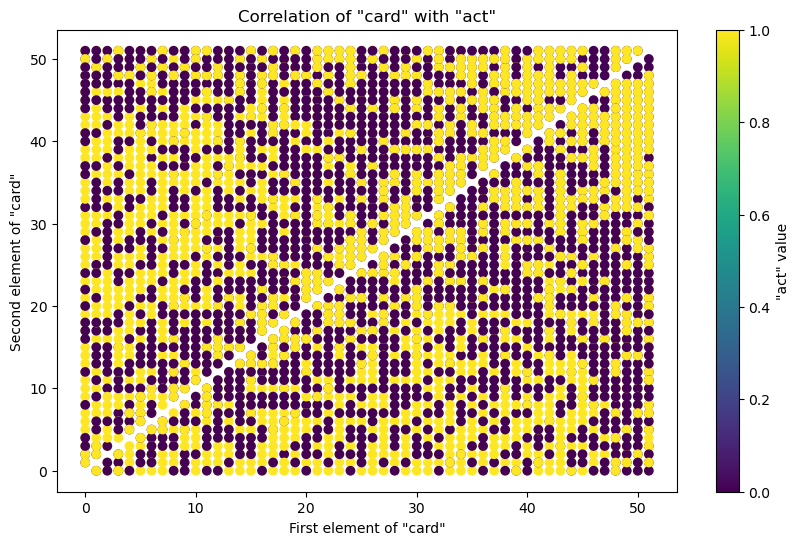

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
vdf = ndf[ndf['cards'].apply(lambda x: len(x) == 2)].copy()

vdf['card_0'] = vdf['cards'].apply(lambda x: x[0])
vdf['card_1'] = vdf['cards'].apply(lambda x: x[1])

# Create a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(vdf['card_0'], vdf['card_1'], c=vdf['act'])
plt.title('Correlation of "card" with "act"')
plt.xlabel('First element of "card"')
plt.ylabel('Second element of "card"')
plt.colorbar(label='"act" value')
plt.show()

In [13]:
all_combinations = []

# Generate all possible combinations of 2 to 5 cards
for r in range(2, 6):
    all_combinations.extend(combinations(deck.values(), r))

len(all_combinations)

2893111

In [14]:
card_order_dict = {"2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8, "9":9, "T":10,"J":11, "Q":12, "K":13, "A":14}

def check_straight_flush(hand):
    if check_flush(hand) and check_straight(hand):
        return True
    else:
        return False

def check_four_of_a_kind(hand):
    values = [i[0] for i in hand]
    value_counts = defaultdict(lambda:0)
    for v in values:
        value_counts[v]+=1
    if sorted(value_counts.values()) == [1,4]:
        return True
    return False

def check_full_house(hand):
    values = [i[0] for i in hand]
    value_counts = defaultdict(lambda:0)
    for v in values:
        value_counts[v]+=1
    if sorted(value_counts.values()) == [2,3]:
        return True
    return False

def check_flush(hand):
    suits = [i[1] for i in hand]
    if len(set(suits))==1:
        return True
    else:
        return False

def check_straight(hand):
    values = [i[0] for i in hand]
    value_counts = defaultdict(lambda:0)
    for v in values:
        value_counts[v] += 1
    rank_values = [card_order_dict[i] for i in values]
    value_range = max(rank_values) - min(rank_values)
    if len(set(value_counts.values())) == 1 and (value_range==4):
        return True
    else:
        #check straight with low Ace
        if set(values) == set(["A", "2", "3", "4", "5"]):
            return True
        return False

def check_three_of_a_kind(hand):
    values = [i[0] for i in hand]
    value_counts = defaultdict(lambda:0)
    for v in values:
        value_counts[v]+=1
    if set(value_counts.values()) == set([3,1]):
        return True
    else:
        return False

def check_two_pairs(hand):
    values = [i[0] for i in hand]
    value_counts = defaultdict(lambda:0)
    for v in values:
        value_counts[v]+=1
    if sorted(value_counts.values())==[1,2,2]:
        return True
    else:
        return False

def check_one_pairs(hand):
    values = [i[0] for i in hand]
    value_counts = defaultdict(lambda:0)
    for v in values:
        value_counts[v]+=1
    if 2 in value_counts.values():
        return True
    else:
        return False
  

def check_hand(hand):
    combin = list(combinations(hand, 5))
    if len(hand) == 2:
        if check_one_pairs(hand):
            return "One Pair"
        else:
            return "High Card"
    
    highest_comb = 1
    for comb in combin:
        if check_straight_flush(comb):
            highest_comb = 9
        elif check_four_of_a_kind(comb):
            if highest_comb < 8:
                highest_comb = 8
        elif check_full_house(comb):
            if highest_comb < 7:
                highest_comb = 7
        elif check_flush(comb):
            if highest_comb < 6:
                highest_comb = 6
        elif check_straight(comb):
            if highest_comb < 5:
                highest_comb = 5
        elif check_three_of_a_kind(comb):
            if highest_comb < 4:
                highest_comb = 4
        elif check_two_pairs(comb):
            if highest_comb < 3:
                highest_comb = 3
        elif check_one_pairs(comb):
            if highest_comb < 2:
                highest_comb = 2
        else:
            if highest_comb < 1:
                highest_comb = 1

    comb = {1: "High Card", 2: "One Pair", 3: "Two Pairs", 4: "Three of a Kind", 5: "Straight", 6: "Flush", 7: "Full House", 8: "Four of a Kind", 9: "Straight Flush"}
    return comb[highest_comb]

deck_reverse = {v: k for k, v in deck.items()}

check_hand(['7d','7h'])

'One Pair'

In [15]:
  
ndf['Highest'] = ndf['cards'].apply(lambda lst: [deck_reverse[i] for i in lst]).apply(check_hand)
ndf.head()

,cards,act,Highest
0,"(32, 40)",0,High Card
1,"(42, 12)",1,High Card
2,"(36, 0)",1,High Card
3,"(25, 27)",0,One Pair
4,"(35, 48)",0,High Card


In [16]:
ndf['Highest'].value_counts()

Highest
Flush              168621
One Pair            34052
High Card           31933
Two Pairs            8724
Straight Flush       4581
Three of a Kind      3672
Straight             1412
Full House           1082
Four of a Kind        662
Name: count, dtype: int64

In [17]:
ndf[ndf['Highest'] == 'Royal']['act'].value_counts()

Series([], Name: count, dtype: int64)

In [18]:
ndf.to_csv('./out/processed.csv', index=False)

In [19]:
mlb = MultiLabelBinarizer()
le = LabelEncoder()

mlb.fit(all_combinations)

le.fit(['Flush', 'Four of a Kind', 'Full House', 'High Card', 'One Pair', 'Royal Flush', 'Straight', 'Straight Flush', 'Three of a Kind', 'Two Pairs'])

X_cards = mlb.transform(ndf['cards'].apply(lambda x: tuple(x)))
X_highest = le.transform(ndf['Highest']).reshape(-1, 1)



# Fit the encoder to the 'cards' column
# X = np.concatenate((X_cards, X_highest), axis=1)
X = X_cards
Y = ndf['act']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1998)

model = RandomForestClassifier(n_jobs=-1)

In [20]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
model.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=-1)

In [22]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Test Accuracy: ", accuracy_score(Y_test, pred_test))
print("Training Accuracy: ", accuracy_score(Y_train, pred_train))

Test Accuracy:  0.9156713932242101
Training Accuracy:  0.9827332649772961


In [23]:
filename = 'unhinted_model_9_compress.sav'
dump(model, filename, compress=9)

['unhinted_model_9_compress.sav']

In [76]:
le.classes_


array(['Flush', 'Four of a Kind', 'Full House', 'High Card', 'One Pair',
       'Royal Flush', 'Straight', 'Straight Flush', 'Three of a Kind',
       'Two Pairs'], dtype='<U15')

In [ ]:
loaded_model = load('model.sav')

# New data
new_data = ['6c', 'Qs', 'Td', '8d', '2c']

highest_combo = check_hand(new_data)
new_data = [deck[card] for card in new_data]
new_data_combo = le.transform([highest_combo]).reshape(-1, 1)

print(new_data)
print(highest_combo)
print(new_data_combo)

new_data = mlb.transform([new_data])
print(model.predict(np.concatenate((new_data, new_data_combo), axis=1)))


In [26]:
loaded_model = load('unhinted_model_9_compress.sav')

# New data
new_data = ['6c', 'Qs', 'Td', '8d', '2c']


new_data = [deck[card] for card in new_data]

new_data = mlb.transform([new_data])
print(model.predict(new_data))

[1]


In [24]:
import sklearn
sklearn.__version__

'1.3.0'

In [ ]:
import random
suits = ['c', 'd', 'h', 's']  # clubs, diamonds, hearts, spades
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', 'T',
         'J', 'Q', 'K', 'A']  # 2-10, Jack, Queen, King, Ace

deck = {rank + suit: i for i, (rank, suit) in enumerate((r, s)
                                                        for r in ranks for s in suits)}

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from itertools import combinations
from joblib import dump, load
mlb = MultiLabelBinarizer()
all_combinations = []
for r in range(2, 6):
    all_combinations.extend(combinations(deck.values(), r))

mlb.fit(all_combinations)

def neural_predict(hand):
    hand = [deck[card] for card in hand]
    hand = mlb.transform([hand])
    nueral_model = load('./model/neural_model.sav')
    return nueral_model.predict(hand)[0]



fold_count = {0: 0, 1: 0}
keys = list(deck.keys())

for _ in range(1000):
    hand = random.sample(keys, 5)
    fold_count[neural_predict(hand)] += 1
print(fold_count)
print('fold_percent: ' + str(fold_count[1] / sum(fold_count.values())))